# Clustering analysis and PCA #

### IMPORTANT: Please make sure that you are using the R kernel to run this notebook.###
We are now switching from the bash kernel to the R kernel. 
The R language provides a number of utilities for genomic data analysis and visualization. We will explore some of these. 

In [6]:
#The preprocessCore library provides a number of functions useful for statistical analysis,
#including functions for data normalization that we will use below. 
library("preprocessCore")

In [7]:
#Change to your $WORK_DIR. The syntax for switching directories in R is a little different than what we used in bash. 
#Use the "setwd" command to switch to your $WORK_DIR 
sunetid="ambenj"
setwd(paste("/srv/scratch/training_camp/work/",sunetid,sep=""))
#The "dir" command will list all files in your current working directory 
dir()

[1] "all_merged.peaks.bed"   "all.fc.bigwig"          "all.fc.txt"            
 [4] "all.peaks.bed"          "all.peaks.sorted.bed"   "all.readcount.txt"     
 [7] "all.tagAlign.files.txt" "data"                   "narrowPeak_files.txt"  
[10] "src"                    "tmp"                    "WT-SCD-Rep1_out"       
[13] "WT-SCD-Rep2_out"        "WT-SCE-Rep1_out"        "WT-SCE-Rep2_out"

In this tutorial we will focus on the clustering and PCA analysis steps of the pipeline: 
![Analysis pipeline](images/part3.png)

In [8]:
#load the fc signal matrix
fc_data=read.table("all.fc.txt",header=TRUE)
rownames(fc_data)=paste(fc_data$Chrom,fc_data$Start,fc_data$End,sep='\t')
#remove the columns we will not use in downstream analysis
fc_data$ID=NULL
fc_data$Chrom=NULL
fc_data$Start=NULL
fc_data$End=NULL

head(fc_data)


,cln3.SCD.Rep1_R1_001,cln3.SCD.Rep2_R1_001,cln3.SCE.0_6MNaCl.Rep1_R1_001,cln3.SCE.0_6MNaCl.Rep2_R1_001,cln3.SCE.Rep1_R1_001,cln3.SCE.Rep2_R1_001,whi5.cln3.SCE.Rep1_R1_001,whi5.cln3.SCE.Rep2_R1_001,whi5.SCE.Rep1_R1_001,whi5.SCE.Rep2_R1_001,WT.SCD.0_6MNaCl.Rep1_R1_001,WT.SCD.0_6MNaCl.Rep2_R1_001,WT.SCD.Rep1_R1_001,WT.SCD.Rep2_R1_001,WT.SCE.0_6MNaCl.Rep1_R1_001,WT.SCE.0_6MNaCl.Rep2_R1_001,WT.SCE.Rep1_R1_001,WT.SCE.Rep2_R1_001
chrI 0 781,1.208200,1.25879,2.07344,2.96920,2.30141,2.620360,1.86505,2.87168,2.52725,0.965167,2.732390,2.678760,1.902120,1.742660,2.824290,2.64587,6.503000,2.16280
chrI 6332 6549,1.789460,1.78578,1.71822,1.41723,2.07408,0.991613,2.20631,1.89088,1.90687,1.548170,0.965532,0.875607,1.307480,1.768650,2.397240,2.57230,0.749380,2.00934
chrI 9138 9609,0.919425,1.04169,1.42442,1.20006,1.57440,1.229620,1.41871,1.42797,1.24815,1.349260,0.399234,0.432705,0.947398,0.885702,0.990087,1.25556,0.437034,1.92736
chrI 20611 21197,1.309060,1.33000,1.87316,1.53013,1.78733,1.420630,1.75343,1.94326,1.89821,0.893881,1.219550,1.902890,1.173620,1.656420,2.288660,2.16635,2.367550,1.68974
chrI 28155 29092,2.053610,2.19933,1.27016,1.17653,1.56107,1.584830,1.71036,1.50945,1.32600,1.294480,0.856320,1.021800,2.141430,1.950980,1.204790,1.23796,1.152350,1.53740
chrI 29173 30197,1.620580,1.63262,1.67228,1.47503,1.84358,1.681200,1.81347,1.65736,1.82927,1.663420,0.629096,0.828475,1.480830,1.735870,1.853940,1.83819,0.836652,1.99762


In [9]:
#normalize the data 
#quantile normalization 
fc_data_matrix=normalize.quantiles(data.matrix(asinh(fc_data)))

In [10]:
colnames(fc_data_matrix)=names(fc_data)
rownames(fc_data_matrix)=rownames(fc_data)

In [11]:
head(fc_data_matrix)

,cln3.SCD.Rep1_R1_001,cln3.SCD.Rep2_R1_001,cln3.SCE.0_6MNaCl.Rep1_R1_001,cln3.SCE.0_6MNaCl.Rep2_R1_001,cln3.SCE.Rep1_R1_001,cln3.SCE.Rep2_R1_001,whi5.cln3.SCE.Rep1_R1_001,whi5.cln3.SCE.Rep2_R1_001,whi5.SCE.Rep1_R1_001,whi5.SCE.Rep2_R1_001,WT.SCD.0_6MNaCl.Rep1_R1_001,WT.SCD.0_6MNaCl.Rep2_R1_001,WT.SCD.Rep1_R1_001,WT.SCD.Rep2_R1_001,WT.SCE.0_6MNaCl.Rep1_R1_001,WT.SCE.0_6MNaCl.Rep2_R1_001,WT.SCE.Rep1_R1_001,WT.SCE.Rep2_R1_001
chrI 0 781,0.9311273,1.0082607,1.4145295,1.820368,1.602675,1.6890289,1.368837,1.790821,1.626016,0.8332902,1.5870026,1.6040939,1.402598,1.3271236,1.5932344,1.6014339,1.926130,1.436751
chrI 6332 6549,1.4394653,1.4131992,1.2134583,1.220955,1.508881,0.9256966,1.524216,1.428887,1.391639,1.7738450,0.9542113,0.8389037,1.097075,1.3454482,1.4508523,1.5731566,1.121844,1.351735
chrI 9138 9609,0.6514872,0.8016476,1.0253491,1.072046,1.250111,1.0980937,1.088023,1.141822,1.009105,1.4567547,0.5596793,0.4934858,0.875465,0.6514872,0.7816685,0.9124936,1.019492,1.301277
chrI 20611 21197,1.0330275,1.0649009,1.3008109,1.294784,1.376319,1.2037396,1.304865,1.455986,1.388091,0.7055880,1.0746324,1.3456152,1.020613,1.2670121,1.4036085,1.4061573,1.439735,1.157107
chrI 28155 29092,1.6800898,1.6846120,0.9256966,1.055524,1.240898,1.2908964,1.280257,1.197675,1.058196,1.3742433,0.8789765,0.9404476,1.516903,1.4625493,0.8884023,0.8993264,1.226584,1.061622
chrI 29173 30197,1.3066965,1.2947840,1.1828668,1.257969,1.403609,1.3464583,1.339471,1.294600,1.352433,1.8894565,0.7428515,0.8053596,1.190398,1.3225877,1.2160960,1.2424806,1.147522,1.344001


Now, we load the matrix of read counts for each peak using the same series of commands as we used above for the fold change data matrix. 

In [12]:
#load the read count matrix
count_data=read.table("all.readcount.txt",header=TRUE)
rownames(count_data)=paste(count_data$Chrom,count_data$Start,count_data$End,sep='\t')
#remove the columns we will not use 
count_data$Chrom=NULL
count_data$Start=NULL
count_data$End=NULL
count_data$ID=NULL
head(count_data)

#quantile normalize 
count_data_matrix=normalize.quantiles(data.matrix(asinh(count_data)))
colnames(count_data_matrix)=names(count_data)
rownames(count_data_matrix)=rownames(count_data)
head(count_data_matrix)

,cln3.SCD.0_6MNaCl.Rep1_R1_001,cln3.SCD.0_6MNaCl.Rep2_R1_001,cln3.SCD.Rep1_R1_001,cln3.SCD.Rep2_R1_001,cln3.SCE.0_6MNaCl.Rep1_R1_001,cln3.SCE.0_6MNaCl.Rep2_R1_001,cln3.SCE.Rep1_R1_001,cln3.SCE.Rep2_R1_001,whi5.cln3.SCE.Rep1_R1_001,whi5.cln3.SCE.Rep2_R1_001,whi5.SCE.Rep1_R1_001,whi5.SCE.Rep2_R1_001,WT.SCD.0_6MNaCl.Rep1_R1_001,WT.SCD.0_6MNaCl.Rep2_R1_001,WT.SCD.Rep1_R1_001,WT.SCD.Rep2_R1_001,WT.SCE.0_6MNaCl.Rep1_R1_001,WT.SCE.0_6MNaCl.Rep2_R1_001,WT.SCE.Rep1_R1_001,WT.SCE.Rep2_R1_001
chrI 0 781,0,0,151,191,226,158,210,127,292,296,232,188,83,246,25,182,241,203,9,244
chrI 6332 6549,0,0,537,820,1342,1050,1157,590,1460,1624,1562,713,590,1585,115,732,2227,2032,90,1230
chrI 9138 9609,0,0,175,222,366,251,304,160,401,483,410,261,143,379,34,220,379,383,17,344
chrI 20611 21197,0,0,249,309,369,282,316,189,394,406,322,314,134,342,60,370,334,310,19,410
chrI 28155 29092,0,0,50,50,48,37,42,22,57,65,55,72,12,49,7,47,65,64,1,60
chrI 29173 30197,0,0,88,115,215,226,225,129,241,390,284,118,86,224,27,164,324,316,25,249


,cln3.SCD.0_6MNaCl.Rep1_R1_001,cln3.SCD.0_6MNaCl.Rep2_R1_001,cln3.SCD.Rep1_R1_001,cln3.SCD.Rep2_R1_001,cln3.SCE.0_6MNaCl.Rep1_R1_001,cln3.SCE.0_6MNaCl.Rep2_R1_001,cln3.SCE.Rep1_R1_001,cln3.SCE.Rep2_R1_001,whi5.cln3.SCE.Rep1_R1_001,whi5.cln3.SCE.Rep2_R1_001,whi5.SCE.Rep1_R1_001,whi5.SCE.Rep2_R1_001,WT.SCD.0_6MNaCl.Rep1_R1_001,WT.SCD.0_6MNaCl.Rep2_R1_001,WT.SCD.Rep1_R1_001,WT.SCD.Rep2_R1_001,WT.SCE.0_6MNaCl.Rep1_R1_001,WT.SCE.0_6MNaCl.Rep2_R1_001,WT.SCE.Rep1_R1_001,WT.SCE.Rep2_R1_001
chrI 0 781,4.595457,4.579918,5.266124,5.198576,5.089005,5.180340,5.133674,5.284057,5.146874,5.135967,5.056919,5.248326,5.196928,5.288166,4.963962,5.120661,4.918846,4.797116,5.082718,5.038239
chrI 6332 6549,4.595457,4.579918,6.839678,6.883510,6.917704,6.735758,6.655868,6.639556,6.632177,6.705987,6.697660,7.013615,6.732309,6.883510,6.561749,6.653742,6.963837,6.983823,6.441846,6.655868
chrI 9138 9609,4.595457,4.579918,5.423253,5.371794,5.565463,5.589647,5.472595,5.474079,5.432989,5.572662,5.531520,5.703745,5.610861,5.636693,5.277552,5.313086,5.323339,5.371794,5.429522,5.352965
chrI 20611 21197,4.595457,4.579918,5.839336,5.706779,5.573463,5.685017,5.512894,5.619310,5.417747,5.423511,5.329402,5.961139,5.562072,5.548454,5.831260,5.842036,5.196128,5.185368,5.504285,5.521861
chrI 28155 29092,4.595457,4.579918,4.033213,3.767401,3.533253,3.806819,3.622590,3.754144,3.581768,3.705101,3.704719,4.128598,3.683515,3.988273,3.767401,3.704719,3.754144,3.704719,4.014712,3.638978
chrI 29173 30197,4.595457,4.579918,4.645652,4.656027,5.040152,5.494503,5.189706,5.300533,4.974650,5.394268,5.224746,4.707548,5.223505,5.210991,5.043236,4.993420,5.171533,5.205838,5.662807,5.056515


Much better! After quantile normalization, the read counts and fold change values across samples are on the same scale. 

## Missing R packages##

When running the scripts in this section, if you get an error saying the gplots package has not been installed, you can install the package locally by  running the **3.5 Install R packages** notebook.

## Hierarchical Clustering of Fold Change Signal Across Samples ##

Cluster analysis is a simple way to visualize patterns in the data. By clustering peaks according to their signal across different time points, we may find groups of peaks that have similar behavior across these time points. By clustering samples according to their signal across peaks, we can perform a simple sanity check of data quality ‐ samples of the same time point should cluster together.

In [13]:
library(gplots)
library(RColorBrewer)


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



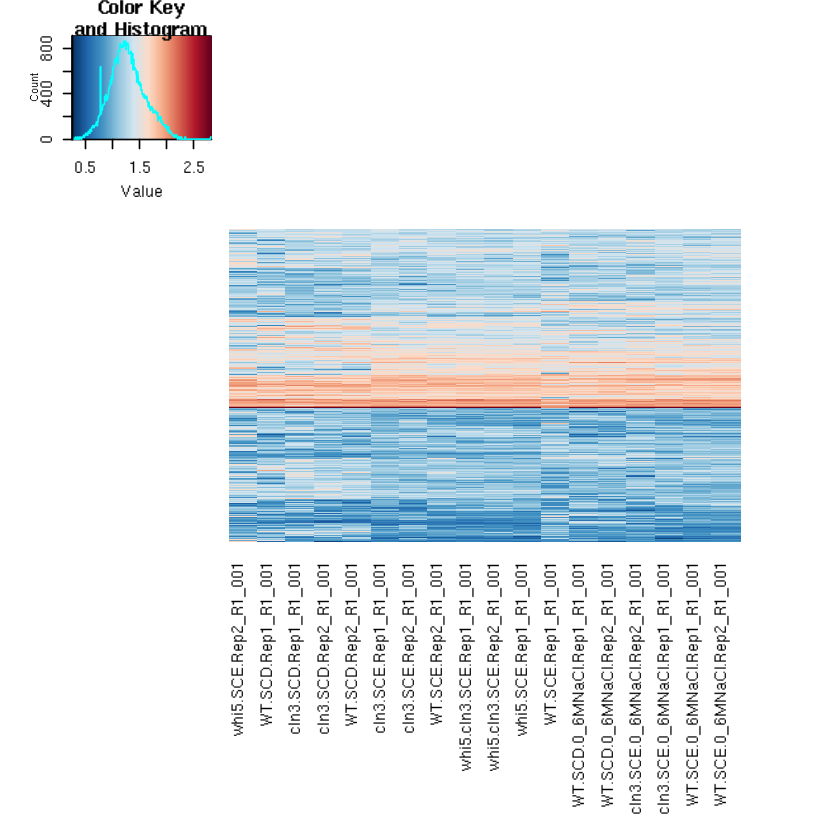

In [14]:
heatmap.2(fc_data_matrix,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          dendrogram = "none",
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")



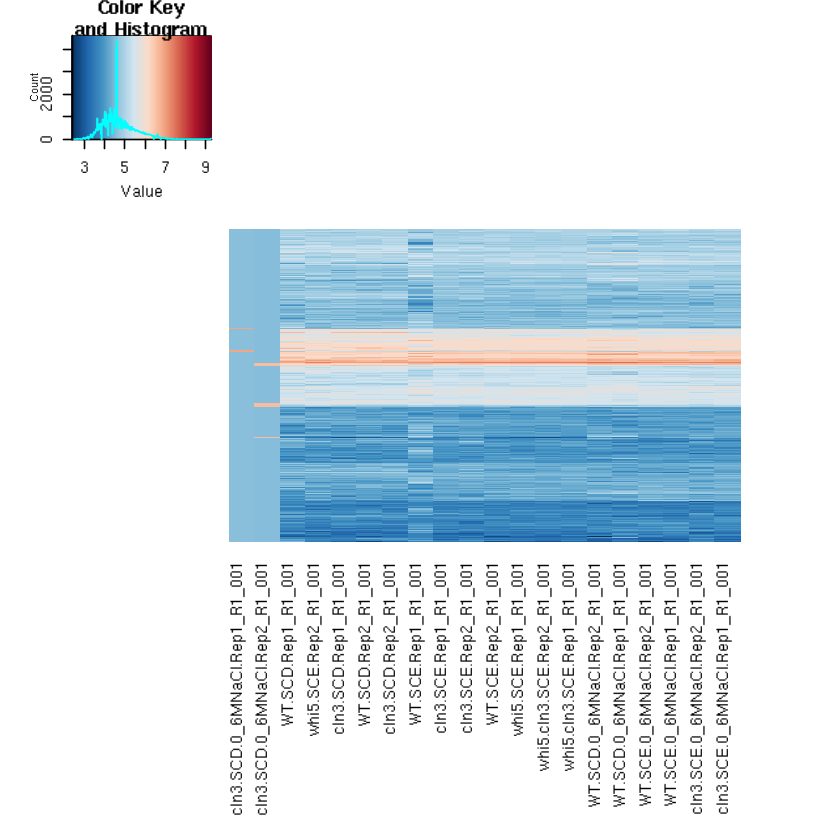

In [15]:
heatmap.2(count_data_matrix,
          scale     = "none",
          col       = rev(colorRampPalette(brewer.pal(10, "RdBu"))(256)),
          distfun   = function(x) dist(x,method="euclidean"),
          hclustfun = function(x) hclust(x, method="ward.D"),
          Rowv=TRUE,
          Colv=TRUE,
          dendrogram = "none",
          trace="none",
          cexCol = 0.9,
          margins=c(15,5),
          labRow="")

## PCA ##

PCA (Principal Component Analysis) is a way to identify the primary directions of variation in the data. It can also be used for very coarse-grained clustering of samples; similar samples will have similar coordinates along the principal axes.

We will perform PCA on *all.fc.txt*. We treat each sample as a single point in a very high dimensional space (where the dimensionality is equal to the number of genes the vary), and then we will perform dimensionality reduction in this space. We can color-code the PCA plots by "Strain", "Media", "Researcher", or "Rep" to determine which parameter separates the samples most effectively. 

In [16]:
#We run the principle component analysis command in R

#The t() function transposes the data matrix and allows us to cluster the samples, as opposed to the individual peaks,
#by placing the samples in the rows and the peaks in the columns. 
fc.pca=prcomp(t(fc_data_matrix))

We generate a scree plot that shows how much variance in the data is explained by each prinicipal component:

In [17]:
var_explained=round(100*fc.pca$sdev^2/sum(fc.pca$sdev^2),2)
print(var_explained)

 [1] 27.21 13.79 10.62  9.94  7.06  5.74  5.35  4.13  3.02  2.53  2.30  1.78
[13]  1.69  1.54  1.22  1.18  0.89  0.00


Let's generate a simple bar graph to better illustrate the variance explained by each PC.


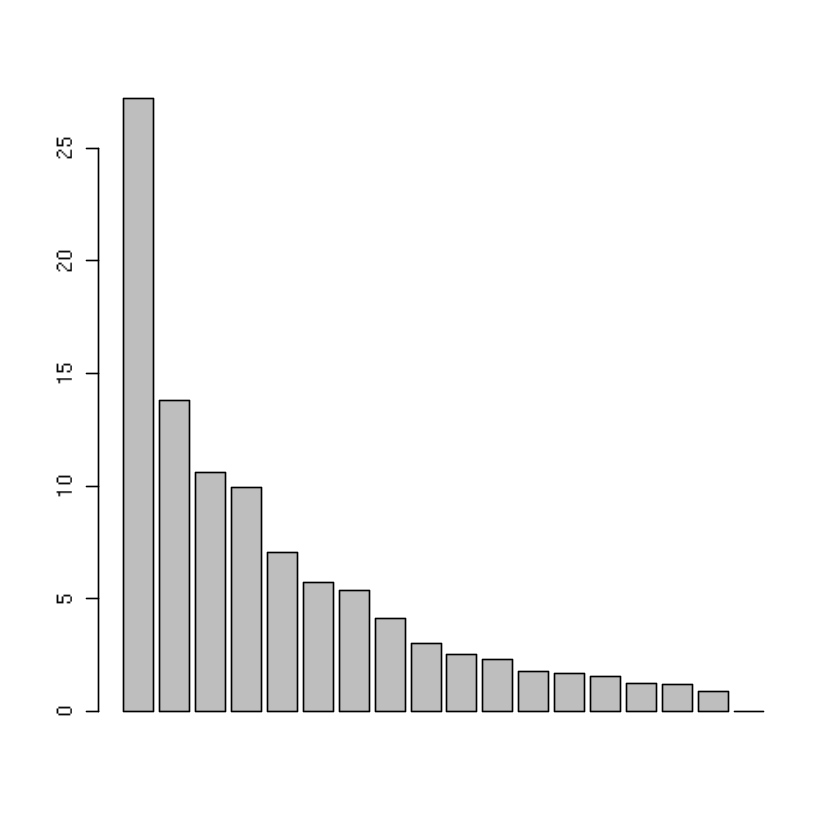

In [18]:
barplot(var_explained)

We can also plot the first few prinicpal components to see if they correlate with any of our experimental variables: 

    * Strain of yeast 
    * Media 
    
We also expect replicates for the same sample to cluster closely together.

Finally, we should make sure to check for any unintended batch effects in the data. For example, it's posssible that samples generated by one researcher may exhibit a systematic difference from samples generated by a different researcher. We should check for this bias and correct it if possible. 


    

In [19]:
#First, we load our metadata file into R to help us color samples by replicate, strain, media, and researcher. 
metadata=read.table("/srv/scratch/training_camp/metadata/TC2017_samples.tsv",header=TRUE)
#We use the "factor" function to tell R which variables are categorical rather than continuous 
metadata$Strain=factor(metadata$Strain)
metadata$Media=factor(metadata$Media)
metadata$Sample=factor(metadata$Sample)
metadata$Researcher=factor(metadata$Researcher)
head(metadata)

Researcher,ID,Replicate,Strain,Media,Sample
2,cln3.SCD.0_6MNaCl.Rep1_R1_001,1,cln3,D,clnd3_D
2,cln3.SCD.0_6MNaCl.Rep2_R1_001,2,cln3,D,cln3_D
1,cln3.SCD.Rep1_R1_001,3,cln3,D,cln3_D
1,cln3.SCD.Rep2_R1_001,4,cln3,D,cln3_D
2,cln3.SCE.0_6MNaCl.Rep1_R1_001,1,cln3,E,cln3_E
2,cln3.SCE.0_6MNaCl.Rep2_R1_001,2,cln3,E,cln3_E


In [20]:
#extract the PC columns from the fc.pca object 
pcs=data.frame(fc.pca$x)


In [21]:

#add columns from the metadata file. Do this safely using the "merge" command to make sure the sample ID's 
#from the two data frames are aligned
pcs$ID=rownames(pcs)
pcs_annotated=merge(pcs,metadata,by="ID")
head(pcs_annotated)

ID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC14,PC15,PC16,PC17,PC18,Researcher,Replicate,Strain,Media,Sample
cln3.SCD.Rep1_R1_001,-9.1628017,0.2300455,4.081544,1.9607055,2.258013,-0.4034281,4.8540390,-4.1441136,-2.8214322,⋯,0.5374852,0.06498229,0.062938019,0.06791194,-5.065393e-15,1,3,cln3,D,cln3_D
cln3.SCD.Rep2_R1_001,-9.3653957,-1.7150455,1.687803,-0.6537029,3.755351,-0.6859376,-0.4395726,0.6028025,3.2483604,⋯,0.2123249,0.18292612,-0.158406388,0.05869724,-5.417541e-15,1,4,cln3,D,cln3_D
cln3.SCE.0_6MNaCl.Rep1_R1_001,4.0328073,2.2984673,1.797554,0.5213120,-0.197333,-4.2214135,0.3118056,0.6616174,-1.8403281,⋯,-1.3004199,0.47442935,0.279737917,0.03250126,-3.469447e-15,2,1,cln3,E,cln3_E
cln3.SCE.0_6MNaCl.Rep2_R1_001,5.6614928,-1.2487459,-1.035066,1.8301725,1.851586,-5.8988958,-1.6075780,-2.7577913,2.8792805,⋯,1.0709279,-0.22366273,0.002174244,0.16735145,-1.464107e-15,2,2,cln3,E,cln3_E
cln3.SCE.Rep1_R1_001,0.7789643,2.5749571,-1.002582,-3.0964465,1.854686,-0.2069797,-2.2205274,-0.6708362,-0.9494938,⋯,-1.2601553,-0.12580669,0.209533469,0.02271910,-3.622103e-15,1,3,cln3,E,cln3_E
cln3.SCE.Rep2_R1_001,0.4254997,-0.4498281,-3.754259,-3.6885022,2.978881,-1.0670808,-3.7792859,-0.6749801,-3.2297844,⋯,-0.7559832,0.03553653,-0.078045114,-0.06139429,-3.150258e-15,1,4,cln3,E,cln3_E


Now, we can use the ggplot package in R to generate scatterplots of PC1 vs PC2, PC2 vs PC3, etc and color-code
by experimental variables. 


In [22]:
library(ggplot2)

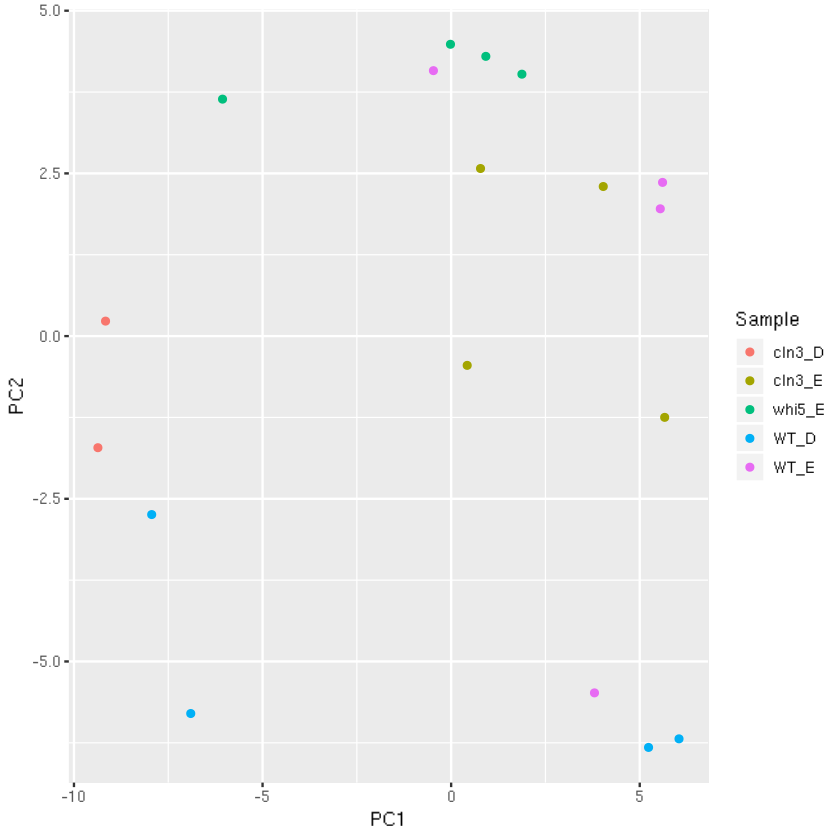

In [23]:
#Plot pc1 vs pc2, color by Sample -- that is, all replicates for the same sample should be the same color. 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Sample))+
geom_point()


We should see replicates of the same sample clustering close together. Do we see this in the scatterplot above?

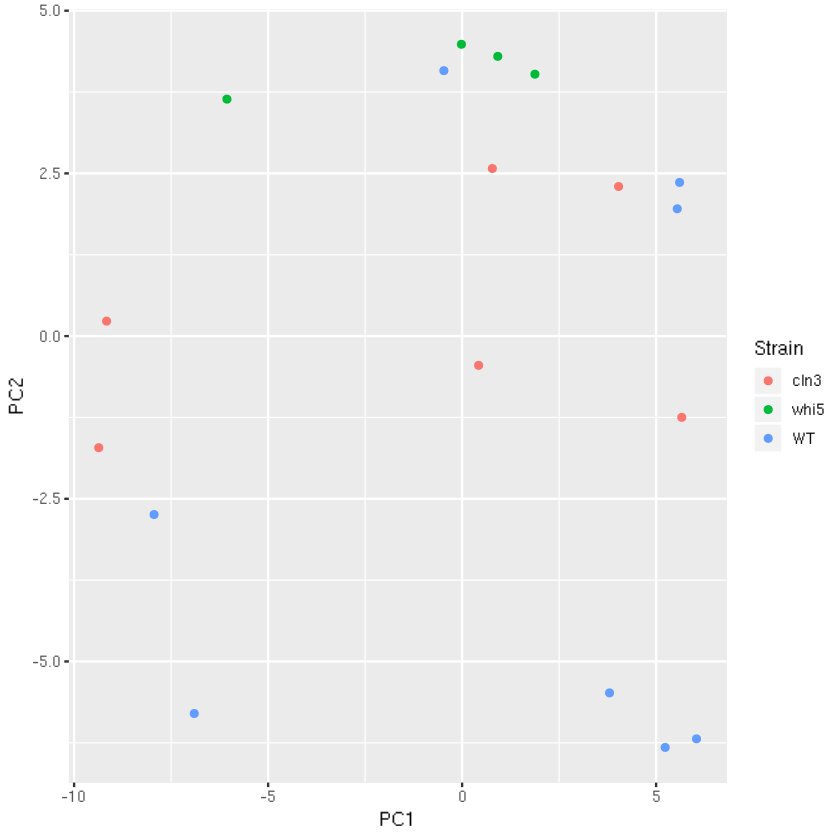

In [24]:

#Plot pc1 vs pc2, color by Strain 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Strain))+
geom_point()



The scatterplot tells us that principle component 2 (PC2) captures variance in the dataset due to strain. 

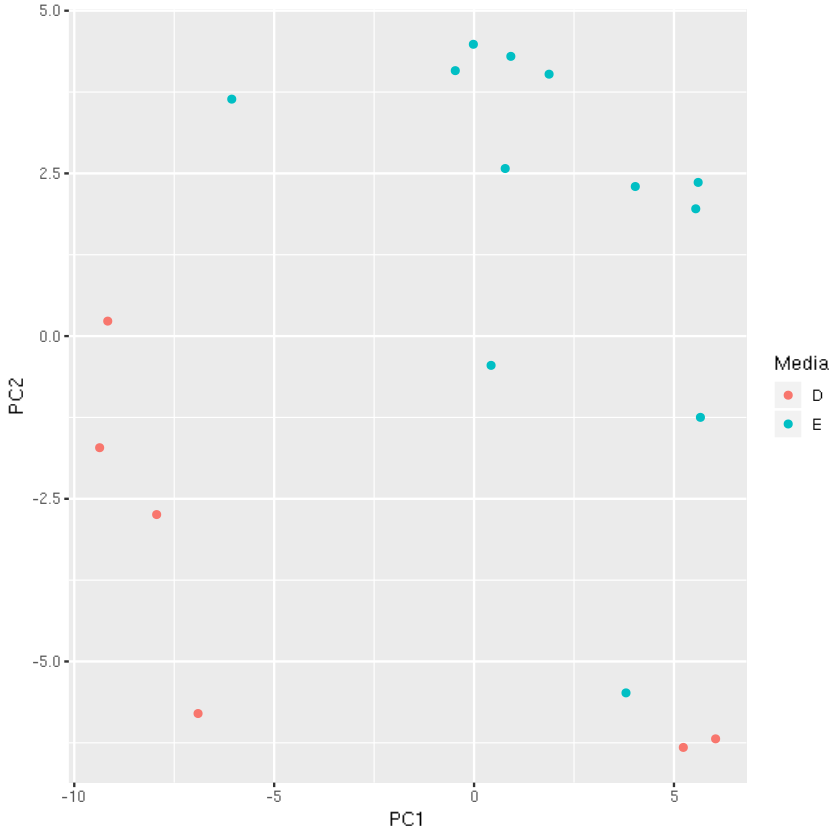

In [25]:
#Plot pc1 vs pc2, color by Media 
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Media))+
geom_point()



We see that Principal component 1 (PC1) captures variation in the data due to media. 


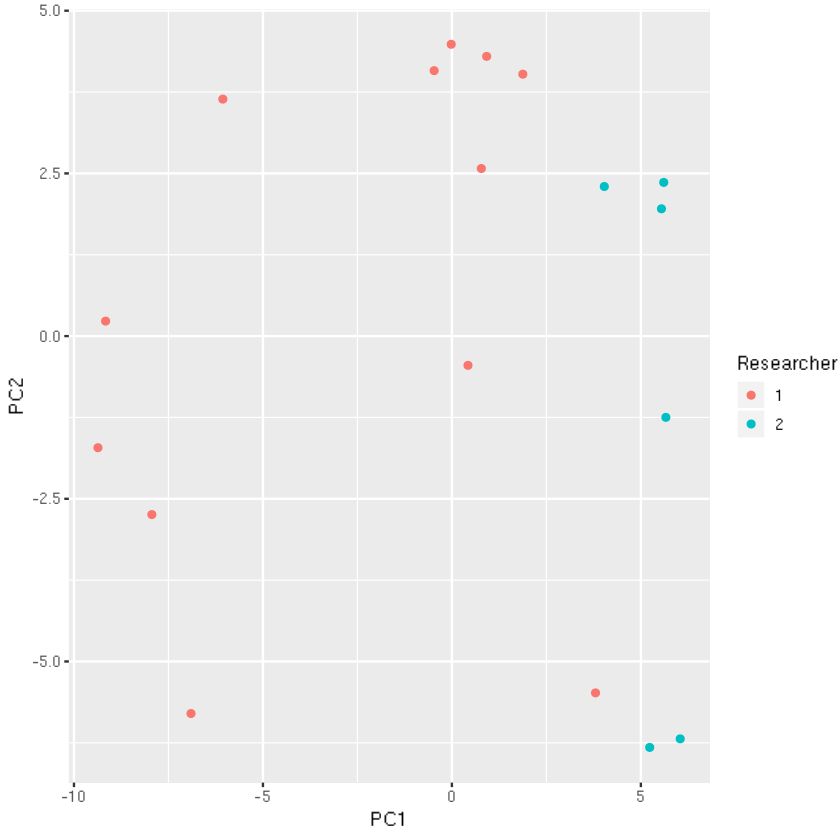

In [26]:
#Plot pc1 vs pc2, color by Researcher -- here, we're checking for a batch effect based on researcher.
ggplot(data=pcs_annotated,aes(x=PC1,y=PC2,color=Researcher))+
geom_point()


Yikes! We do seem to have a batch effect based on researcher -- PC1 captures this effect. This is not surprising, as our design was deliberately confounded for replicates 4 - 6. 

Luckily, there are steps we can take to remove this batch effect. We use the R **limma** package to fit a linear mixed effects model. The explanatory variables are Strain, Media, and Researcher. The output variable is the normalized fold change value in the data matrix. We then subtract out the contribution from "Researcher" (the confounding variable) to the output variable. 

In [27]:
library(limma)

In [32]:
#make sure the row order of the metadata file matches the column order of the fc_data_matrix file. 
rownames(metadata)=metadata$ID
metadata=metadata[colnames(fc_data_matrix),]


In [34]:
#design the model using entries from our metadata file 
mod=model.matrix(~Strain+Media+Researcher,data=metadata)

#fit the model to the data 
fit=lmFit(fc_data_matrix,design=mod)

head(coefficients(fit))

#We note that column 5 in the model captures the batch effect from the "Researcher" variable. We can remove the 
#contribution of this variable from the data: 
batch_contribution=coefficients(fit)[,5]%*% t(fit$design[,5])
fc_data_matrix_corrected=fc_data_matrix-batch_contribution

,(Intercept),Strainwhi5,StrainWT,MediaE,Researcher2
chrI 0 781,1.150848,-0.08644370,0.18889101,0.3403368,0.09977722
chrI 6332 6549,1.232716,0.17505948,-0.03646699,0.1218712,-0.08106270
chrI 9138 9609,0.778591,-0.01539171,-0.05564375,0.4107269,-0.20785946
chrI 20611 21197,1.064030,-0.04014685,0.07280421,0.1897496,0.06520231
chrI 28155 29092,1.611436,-0.13219373,-0.18018455,-0.2516498,-0.39215125
chrI 29173 30197,1.257117,0.03326984,-0.10382353,0.1786029,-0.23236640


Let's re-run the PCA analysis on  fc_data_matrix_corrected to make sure we're no longer observing a batch effect 
due to researcher.



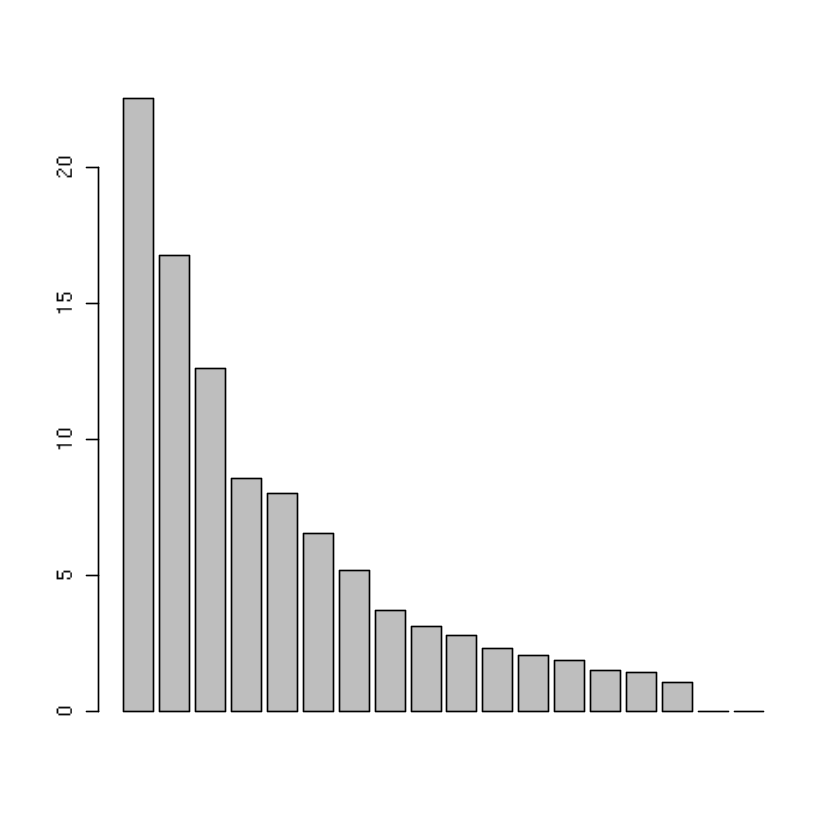

In [35]:
fc.pca.corrected=prcomp(t(fc_data_matrix_corrected))
var_explained=round(100*fc.pca.corrected$sdev^2/sum(fc.pca.corrected$sdev^2),2)
barplot(var_explained)
pcs.corrected=data.frame(fc.pca.corrected$x)
pcs.corrected$ID=rownames(pcs.corrected)
pcs_annotated.corrected=merge(pcs.corrected,metadata,by="ID")

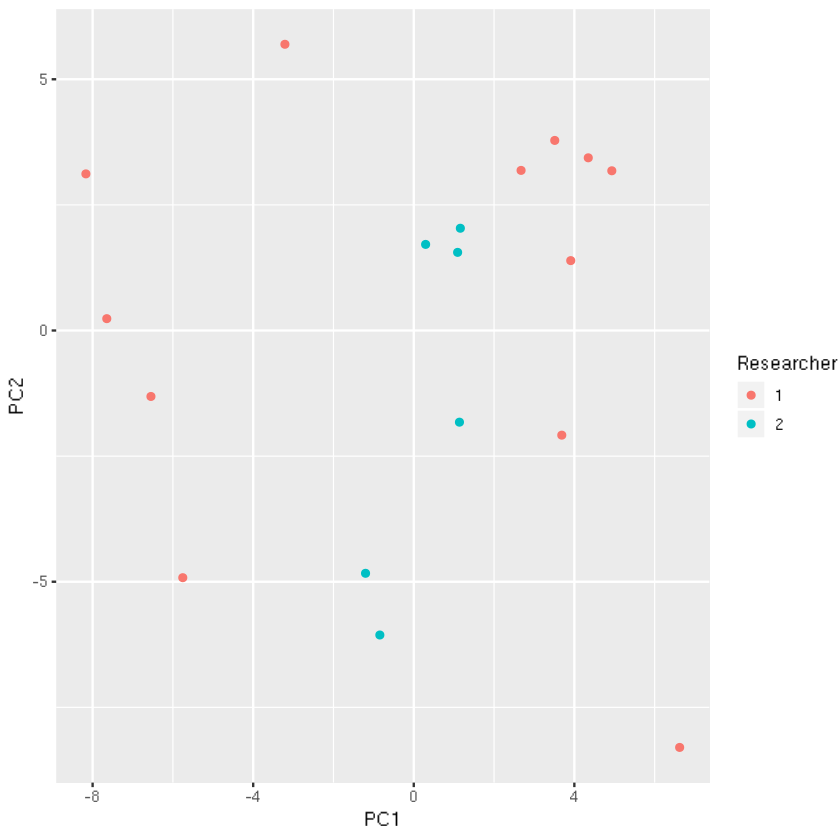

In [36]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Researcher))+
geom_point()

Excellent! We no longer see samples clustering based on the researcher that performed the experiment. Hopefully, we still see the effects from strain and media, let's verify:

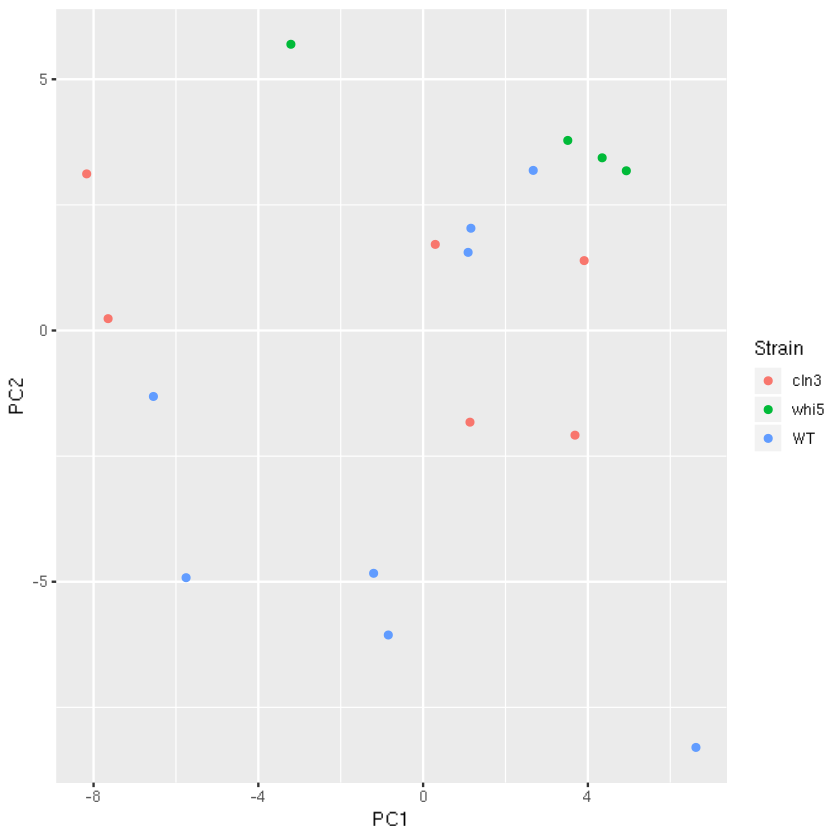

In [37]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Strain))+
geom_point()

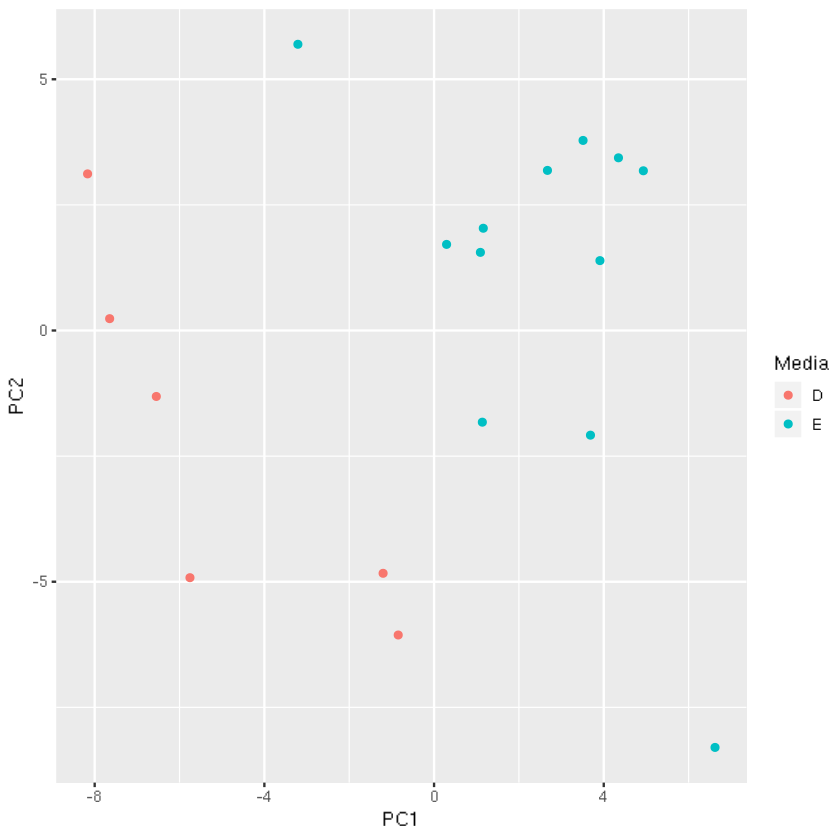

In [38]:
ggplot(data=pcs_annotated.corrected,aes(x=PC1,y=PC2,color=Media))+
geom_point()

Yes, still there. 

Exercise: Generate scatterplots for PC1 vs PC3, and PC2 vs PC3. 

Finally, we'd like to determine how much each peak contributes to PC1, PC2, and PC3. We can look at PC4 and up also, but for the sake of time we'll stick with the first 3 principal components; from the scree plot, we see they explain over 50% of the variance in the data. Primarily we want to get a sense of which peaks are critical in defining the principle components, and in which direction (positive or negative).

In [39]:
contribs_pc1=fc.pca.corrected$rotation[,1]
contribs_pc2=fc.pca.corrected$rotation[,2]
contribs_pc3=fc.pca.corrected$rotation[,3]

#these are lists of contributs from each peak to the corresponding PC
head(contribs_pc1)
length(contribs_pc1)

chrI\t0\t781   chrI\t6332\t6549   chrI\t9138\t9609 chrI\t20611\t21197 
      0.0499109866      -0.0032764070       0.0288593021       0.0274292219 
chrI\t28155\t29092 chrI\t29173\t30197 
     -0.0326966829      -0.0003927467

[1] 3455

In [40]:
#Use the write.table command to write the PC contribution data to output files. 

write.table(contribs_pc1,"pc1_contribs.txt",quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc2,"pc2_contribs.txt",quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
write.table(contribs_pc3,"pc3_contribs.txt",quote=FALSE,col.names=FALSE,row.names=TRUE,sep='\t')
